## Description
In this notebook, we detect outlying signals in the MS images, in both the spatial domain (pixels with atypical spectra) and mz domain (mz values with atypical distribution of intensities over the image). 
Then, we centroid the images and save the results.   

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from additional_functions import plot_summary_spectrum, centroided_ion_image, profile_ion_image

In [3]:
analyzed_mass_range = (700, 900)

In [4]:
bladder_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
bladder_image_shape = (134, 260)

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(


In [5]:
260*134

34840

In [6]:
cerebellum_image = ImzMLParser('MSimages/test_POS.imzML')
cerebellum_image_shape = (21, 81)

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mzML file". Updating name to "mzML format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000615 found with incorrect name "ProteoWizard". Updating name to "ProteoWizard software".
  warn(


In [7]:
21*81

1701

In [8]:
images = [cerebellum_image, bladder_image]
names = ['cerebellum', 'bladder']
shapes = [cerebellum_image_shape, bladder_image_shape]

We'll set a fixed mass axis for all spectra in the profile mode.    
We select a range of m/z values corresponding to most common lipids.  
Note: the number of sampling points should be selected so that it's not too memory-intensive, but also sufficiently high for an accurate centroiding; We verify this in the next sections.  

In [9]:
mass_axis = np.arange(analyzed_mass_range[0], analyzed_mass_range[1], step=0.002)
print('Number of sampling points:', len(mass_axis))
print('Example points:', mass_axis[:10])

Number of sampling points: 100000
Example points: [700.    700.002 700.004 700.006 700.008 700.01  700.012 700.014 700.016
 700.018]


Compare example spectra from the background and the tissue in the cerebellum image:

<IPython.core.display.Javascript object>


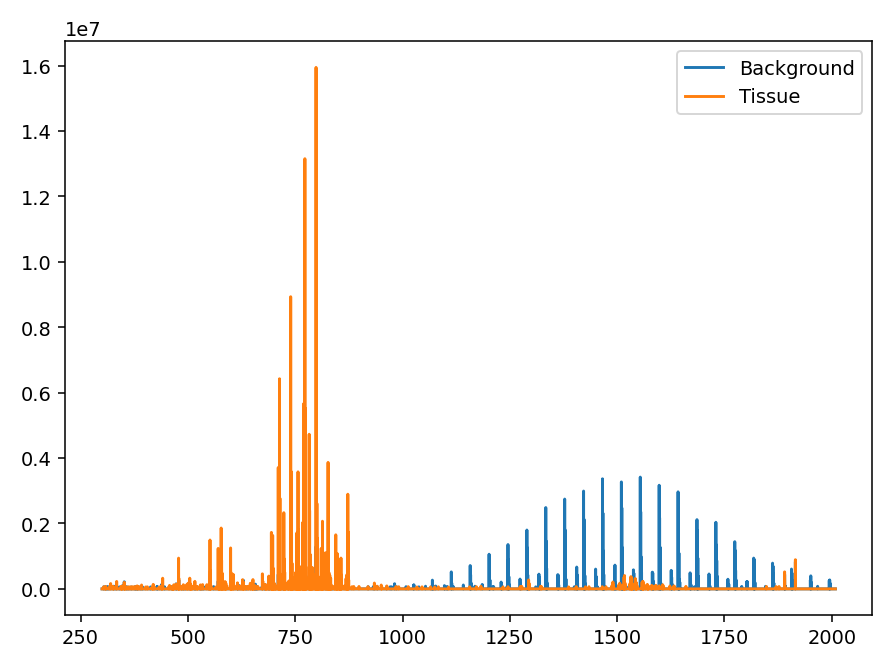

In [85]:
plt.figure()
plt.plot(*cerebellum_image.getspectrum(1283))
plt.plot(*cerebellum_image.getspectrum(756))
plt.legend(['Background', 'Tissue'])
plt.tight_layout()

## Summary spectra

First, we'll generate summary spectra for the images to assess the overall distribution of intensities across the images. We can also identify m/z values with atypical spatial distribution.    

A summary spectrum is a spectrum showing the average intensity, its standard deviation, maximum value across the image, and the minimum value. We'll store it as a numpy array with four columns.   

In [59]:
summary_spectra = [np.zeros((len(mass_axis), 4)), np.zeros((len(mass_axis), 4))]
tic_arrays = []
for im_id, img in enumerate(images):
    print('Processing image:', names[im_id])
    intensity_mean = np.zeros(mass_axis.shape)
    intensity_sd = np.zeros(mass_axis.shape)
    intensity_min = np.zeros(mass_axis.shape) + np.inf
    intensity_max = np.zeros(mass_axis.shape)
    TIC_array = np.zeros(shapes[im_id])
    for idx, (xcoord,ycoord,zcoord) in enumerate(img.coordinates):
        if not idx % 10000:
            print('Processing pixel number', idx)
        mz, intsy = img.getspectrum(idx)
        mz, intsy = np.array(mz), np.array(intsy)
        # Calculate the total ion current by a numerical integration of the intensity
        # We calculate TIC using the whole spectrum - otherwise,
        # if we calculate TIC after restricting to the analyzed mass range,
        # we risk that lipid signals will get overestimated in the background
        # (a very small amount of lipids will get normalized to unit signal).
        # Using the whole spectrum gives us other molecules which are more stably distributed
        # throughout the image, such as matrix adducts
        tic = np.trapz(intsy, mz)  
        TIC_array[ycoord-1, xcoord-1] = tic
        # Resample the intensity measurements in the points of the common mass axis
        # through a linear interpolation. This will also restrict our spectrum to the region of interest.
        intsy = np.interp(mass_axis, mz, intsy)
        assert all(intsy) >= 0        
        # Normalize the intensity by the total ion current 
        # (so that the signal integrates to unity)
        intsy /= tic 
        intensity_mean += intsy
        intensity_max = np.maximum(intensity_max, intsy)
        intensity_min = np.minimum(intensity_min, intsy)
        intensity_sd += intsy**2  
    # the idx variable now stores the index of the last pixel,
    # so it's equal to the number of pixels minus one
    intensity_mean /= (idx+1)
    intensity_sd /= (idx+1)
    intensity_sd -= intensity_mean**2
    assert all(intensity_sd >= 0)
    intensity_sd **= 0.5
    summary_spectra[im_id][:,0] = intensity_mean
    summary_spectra[im_id][:,1] = intensity_sd
    summary_spectra[im_id][:,2] = intensity_min
    summary_spectra[im_id][:,3] = intensity_max
    tic_arrays.append(TIC_array)

Processing image: cerebellum
Processing pixel number 0
Processing image: bladder
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000


Plot the summary spectra:

<IPython.core.display.Javascript object>


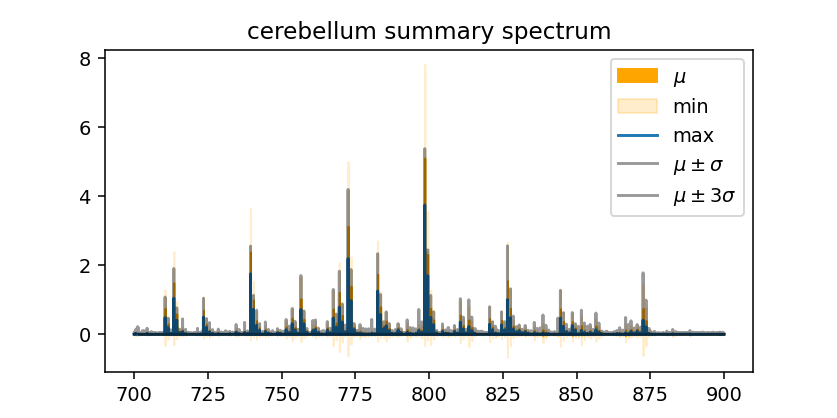

In [60]:
plot_summary_spectrum(mass_axis, summary_spectra[0], plot_title=names[0] + ' summary spectrum', figsize=(6,3))

<IPython.core.display.Javascript object>


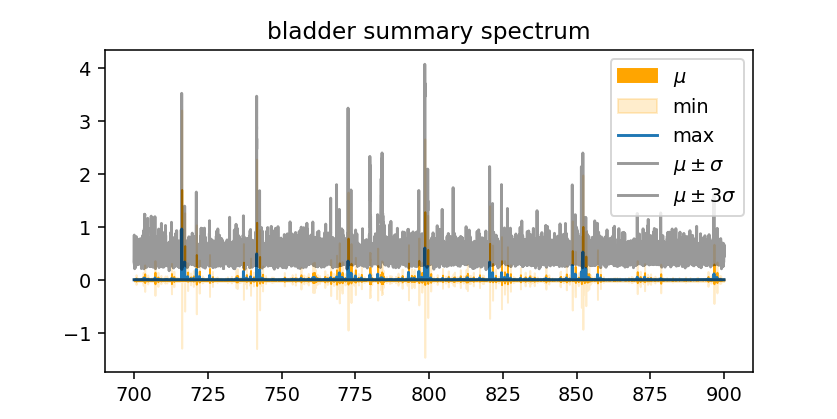

In [61]:
plot_summary_spectrum(mass_axis, summary_spectra[1], plot_title=names[1] + ' summary spectrum', figsize=(6,3))

<IPython.core.display.Javascript object>


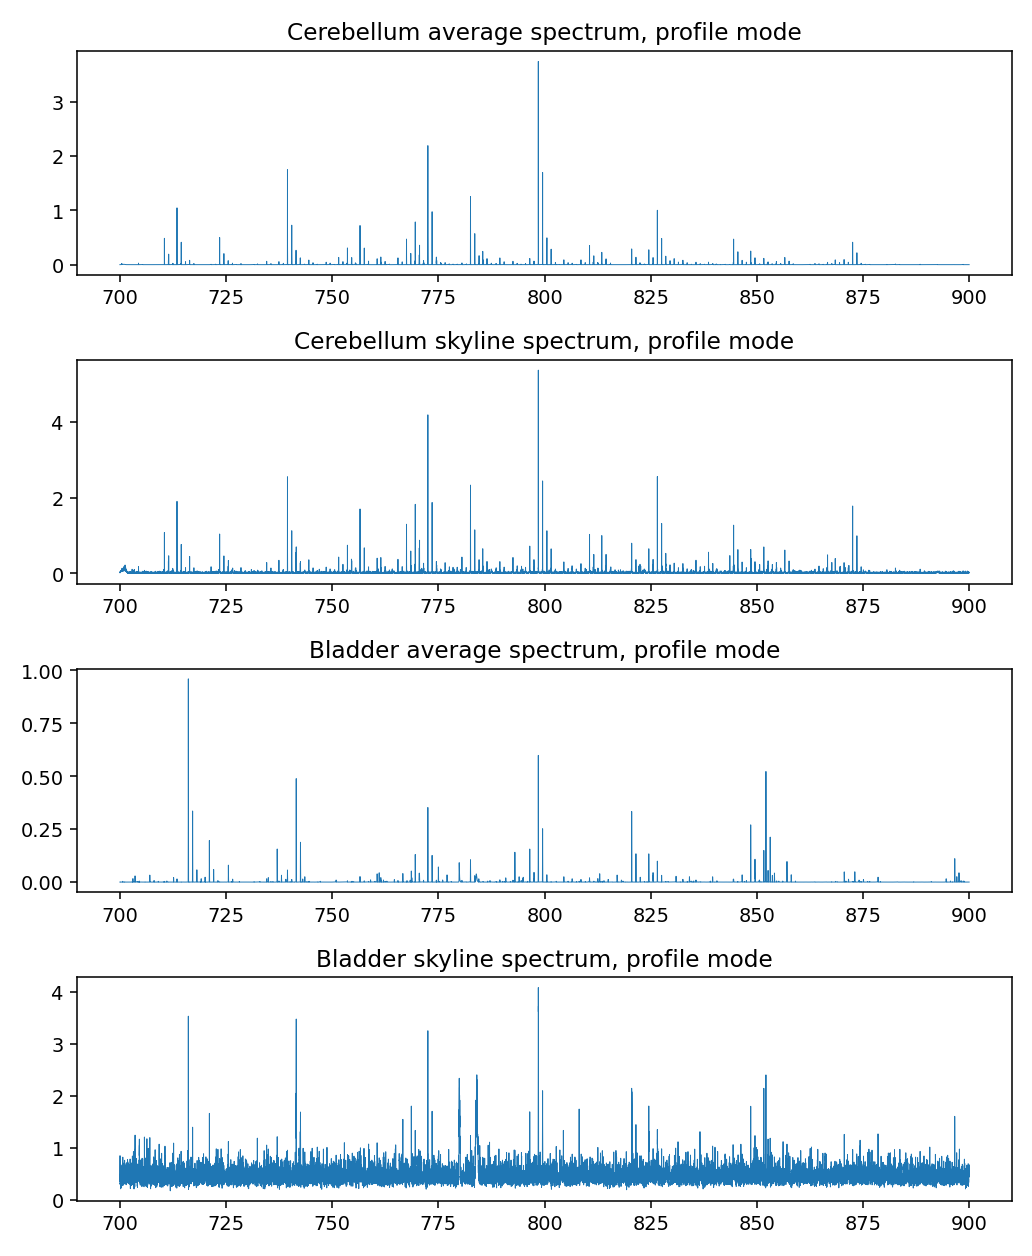

In [65]:
plt.subplots(4, 1, figsize=(7.4,9))
plt.subplot(411)
plt.plot(mass_axis, summary_spectra[0][:,0], lw=0.5)
plt.title('Cerebellum average spectrum, profile mode')
# plt.ylim(0, 9)

plt.subplot(412)
plt.plot(mass_axis, summary_spectra[0][:,3], lw=0.5)
plt.title('Cerebellum skyline spectrum, profile mode')
# plt.ylim(0, 9)

plt.subplot(413)
plt.plot(mass_axis, summary_spectra[1][:,0], lw=0.5)
plt.title('Bladder average spectrum, profile mode')
# plt.ylim(0, 14)

plt.subplot(414)
plt.plot(mass_axis, summary_spectra[1][:,3], lw=0.5)
plt.title('Bladder skyline spectrum, profile mode')
# plt.ylim(0, 14)
plt.tight_layout()
plt.savefig(dpi=300, fname='Figs/Preprocessing/average_and_skyline.png')

In [66]:
(400)/(431.0458 - 431.0303)

25806.451612945624

In [67]:
798.5406/(798.5599-798.5206)

20319.09923662796

In [68]:
798.5406/(798.5522-798.5323)

40127.6683416946

The base width of peaks at around 800 Da is approximately 0.07 Da for the cerebellum and 0.09 Da for the bladder.  
We'll use this fact when centroiding the spectra, to set a maximum width of a peak equal to 0.2 Da (approximately twice the base width - to account for overlapping peaks). We'll assume that broader peaks are artifacts (see e.g. the peak at 541.6 Da in the bladder summary spectrum - we won't deal with such cases).  

Inspect the histograms of total signals across the images:

<IPython.core.display.Javascript object>


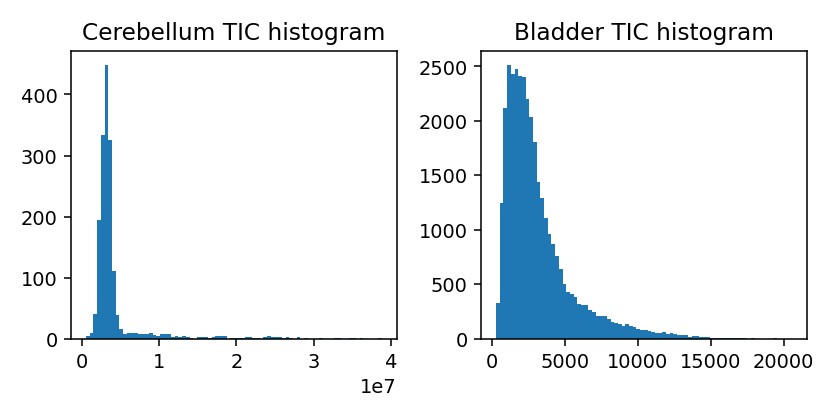

In [69]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.title('Cerebellum TIC histogram')
plt.hist(tic_arrays[0].flatten(), bins=80)
plt.subplot(122)
plt.title('Bladder TIC histogram')
plt.hist(tic_arrays[1].flatten(), bins=80)
plt.tight_layout()
plt.show()

Save the summary spectra:

In [70]:
for i, n in enumerate(names):
    with open(n + '_profile_summary_spectrum.tsv', 'w') as h:
        h.write('\t'.join(['m/z', 'Average', 'SD', 'min', 'max']) + '\n')
        for m, l in zip(mass_axis, summary_spectra[i]):
            h.write(str(m) + '\t' + '\t'.join(map(str, l))+'\n')

## Centroiding the average intensity spectra

We'll centroid the average spectra and save them in order to use in the lipid annotation stage.  
First, construct  `Spectrum` objects with the average spectra in profile modes.  

In [71]:
average_spectra = [Spectrum(confs=list(zip(mass_axis, smry[:,0]))) for smry in summary_spectra]

Compute the centroids of peaks in the average spectra. Integrate peaks within 25% of apex intensity (i.e. 75% of peak height is getting integrated), setting maximum width of the integration region at 0.2 Da.  

In [72]:
centroids = [avg_sp.centroid(peak_height_fraction=0.5, max_width=0.2)[0] for avg_sp in average_spectra]

Verify the centroiding. Construct `Spectrum` objects with centroided average spectra and plot them, overlayed with the average spectra in profile modes. For visualization purposes, we'll rescale the profile spectra so that the centroid heights match the peak heights rather than areas. The scaling factor is selected manually.   

Note: centroid heights may not match peak heights exactly due to differences in peak widths.   

In [73]:
average_centroided = [Spectrum(confs=cntr_list) for cntr_list in centroids]

<IPython.core.display.Javascript object>


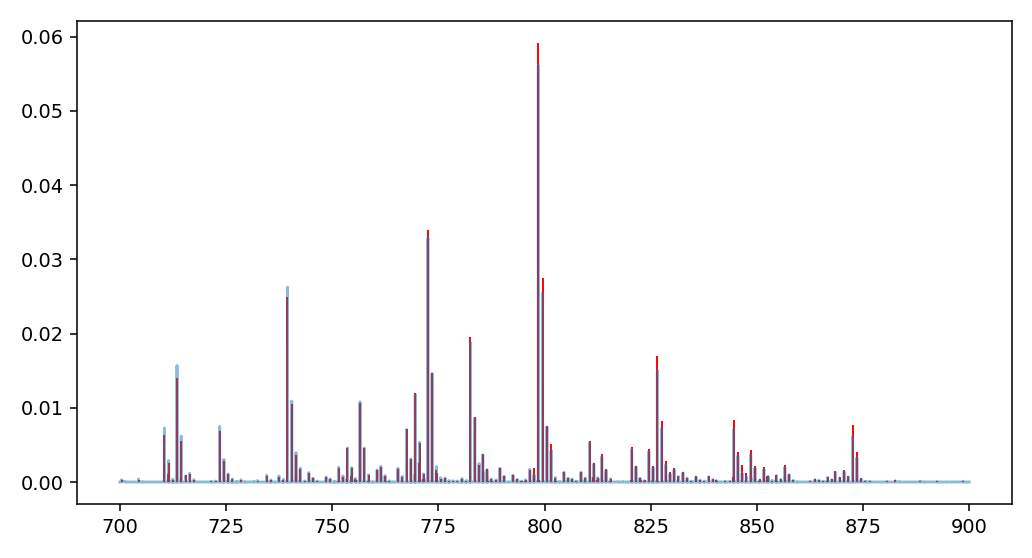

<IPython.core.display.Javascript object>


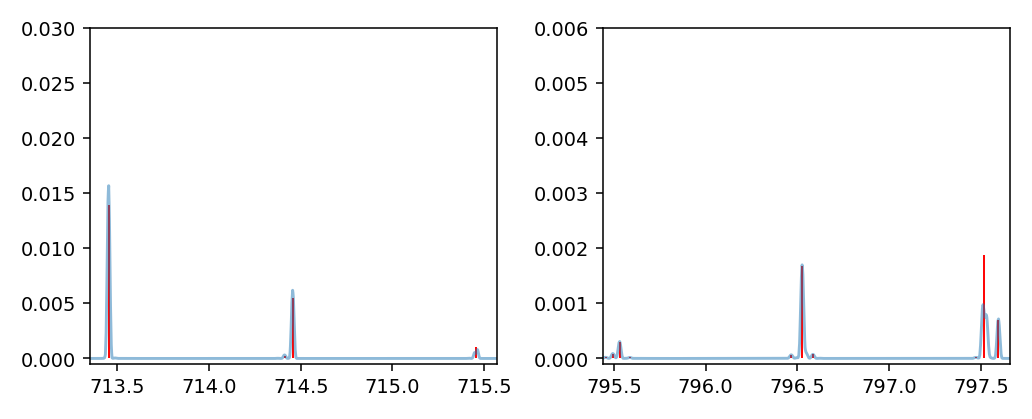

<IPython.core.display.Javascript object>


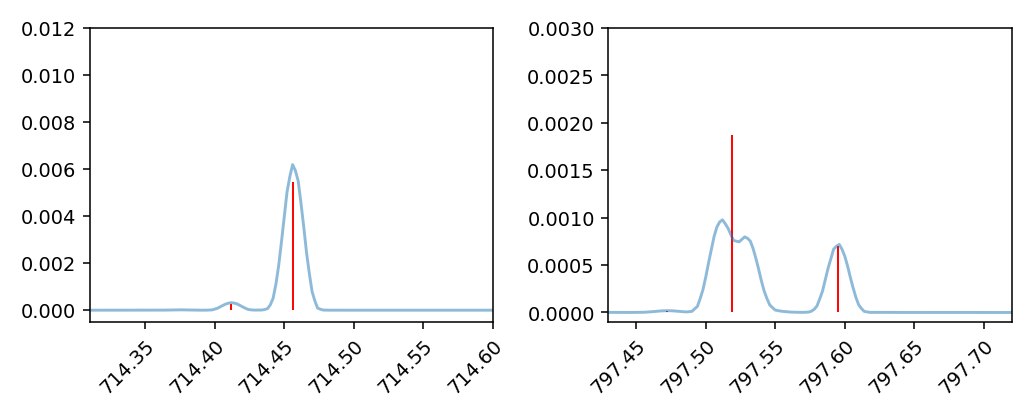

In [74]:
scaling_factor=0.015

plt.figure(figsize=(7.4,4))
# plt.suptitle('Cerebellum average spectrum fragments, profile + centroids')
average_centroided[0].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[0][:,0]*scaling_factor, alpha=0.5)
plt.tight_layout()
plt.savefig('Figs/Preprocessing/cerebellum_centroiding.png', dpi=300)

plt.subplots(1, 2, figsize=(7.4,3), sharey=False)

# plt.suptitle('Cerebellum average spectrum fragments, profile + centroids')
plt.subplot(121)
plt.ylim(-0.0005, 0.03)
average_centroided[0].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[0][:,0]*scaling_factor, alpha=0.5)
plt.xlim(713.35, 715.57)
plt.subplot(122)
plt.ylim(-0.0001, 0.006)
average_centroided[0].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[0][:,0]*scaling_factor, alpha=0.5)
plt.xlim(795.44, 797.6600)
plt.tight_layout()
plt.savefig('Figs/Preprocessing/cerebellum_centroiding_fragments.png', dpi=300)

plt.subplots(1, 2, figsize=(7.4,3.), sharey=False)

# plt.suptitle('Cerebellum zoom-in')
plt.subplot(121)
plt.ylim(-0.0005, 0.012)
average_centroided[0].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[0][:,0]*scaling_factor, alpha=0.5)
plt.xlim(714.31, 714.60)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

plt.subplot(122)
plt.ylim(-0.0001, 0.003)
average_centroided[0].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[0][:,0]*scaling_factor, alpha=0.5)
plt.xlim(797.43, 797.72)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.savefig('Figs/Preprocessing/cerebellum_centroiding_zoom.png', dpi=300)

<IPython.core.display.Javascript object>


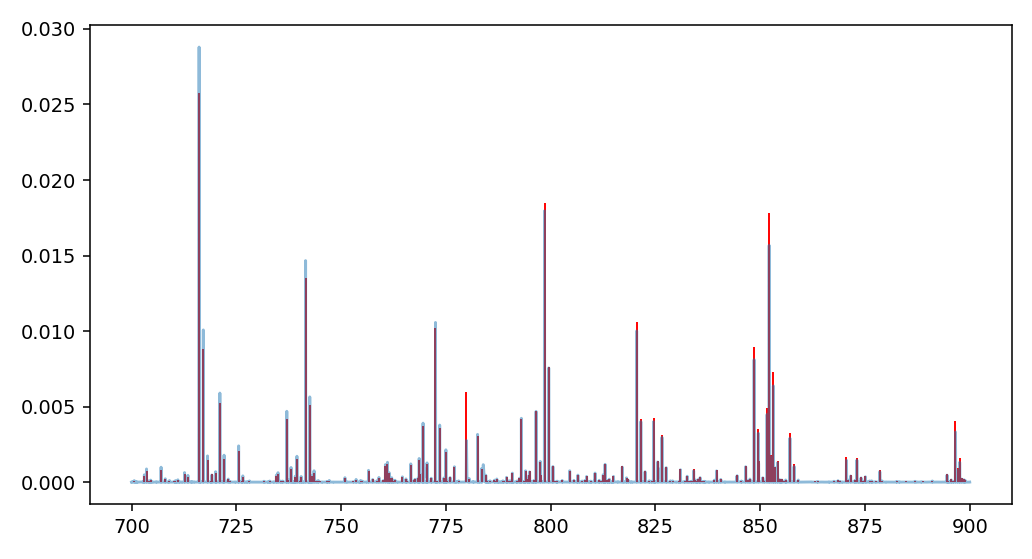

<IPython.core.display.Javascript object>


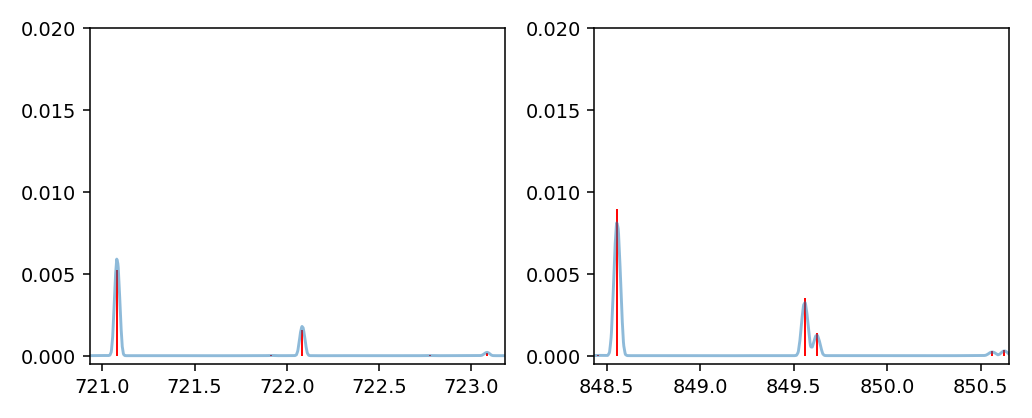

<IPython.core.display.Javascript object>


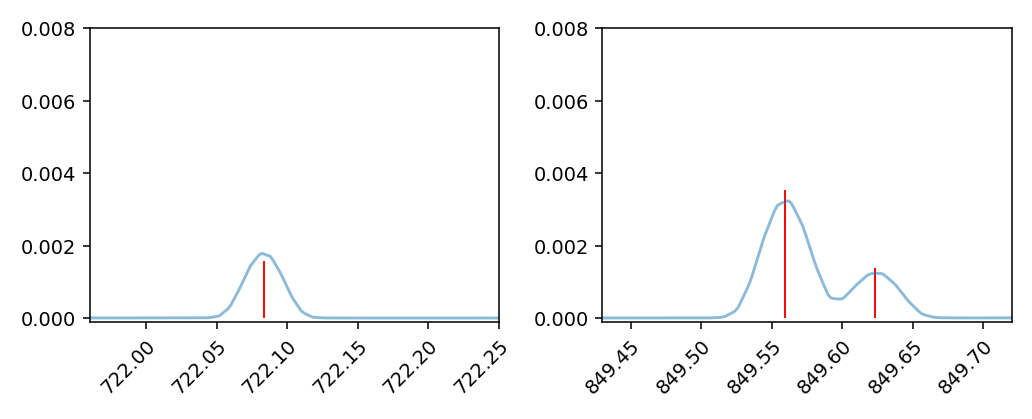

In [75]:
scaling_factor=0.03

plt.figure(figsize=(7.4,4))
# plt.suptitle('Bladder average spectrum fragments, profile + centroids')
average_centroided[1].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[1][:,0]*scaling_factor, alpha=0.5)
plt.tight_layout()
plt.savefig('Figs/Preprocessing/bladder_centroiding.png', dpi=300)

plt.subplots(1, 2, figsize=(7.4,3), sharey=False)
# plt.suptitle('Bladder average spectrum fragments, profile + centroids')
plt.subplot(121)
plt.ylim(-0.0005, 0.02)
average_centroided[1].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[1][:,0]*scaling_factor, alpha=0.5)
plt.xlim(720.931, 723.18)
plt.subplot(122)
plt.ylim(-0.0005, 0.02)
average_centroided[1].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[1][:,0]*scaling_factor, alpha=0.5)
plt.xlim(848.434, 850.654)
plt.tight_layout()
plt.savefig('Figs/Preprocessing/bladder_centroiding_fragments.png', dpi=300)

plt.subplots(1, 2, figsize=(7.4,3.), sharey=False)
# plt.suptitle('Bladder zoom-in')
plt.subplot(121)
plt.ylim(-0.0001, 0.008)
average_centroided[1].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[1][:,0]*scaling_factor, alpha=0.5)
plt.xlim(721.96, 722.25)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

plt.subplot(122)
plt.ylim(-0.0001, 0.008)
average_centroided[1].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[1][:,0]*scaling_factor, alpha=0.5)
plt.xlim(849.43, 849.72)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.savefig('Figs/Preprocessing/bladder_centroiding_zoom.png', dpi=300)

In [24]:
720.931 - 723.18

-2.24899999999991

In [25]:
723.18 - 720.931 

2.24899999999991

In [26]:
779.5 + 2.24899999999991

781.7489999999999

In [27]:
849.72 - 849.43

0.2900000000000773

In [28]:
779.75 + 0.29

780.04

<IPython.core.display.Javascript object>


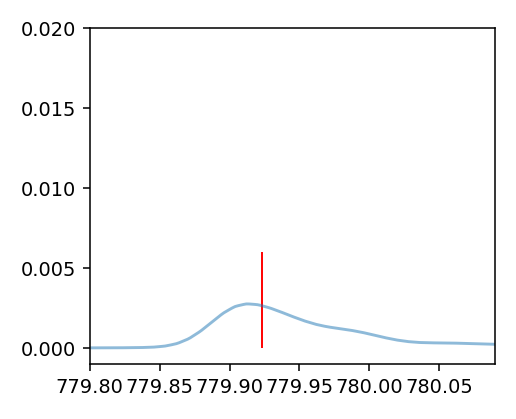

In [76]:
plt.figure(figsize=(3.7,3))
# plt.suptitle('Bladder average spectrum fragments, profile + centroids')
average_centroided[1].plot(color='r', lw=1)
plt.plot(mass_axis, summary_spectra[1][:,0]*scaling_factor, alpha=0.5)
plt.xlim(779.8, 780.09)
plt.ylim(-0.001, 0.02)
plt.tight_layout()
plt.savefig('Figs/Preprocessing/bladder_artifact.png', dpi=300)

Save the centroided average spectrum:

In [77]:
for i, n in enumerate(names):
    with open(n + '_centroided_average_spectrum.tsv', 'w') as h:
        h.write('\t'.join(['m/z', 'intsy']) + '\n')
        for m, l in centroids[i]:
            h.write(str(m) + '\t' + str(l)+'\n')

## Centroiding the images, saving the result

We'll centroid the pixel spectra of the images, using the same settings as for the average spectra, and, simultaneously, we'll save the results in an imzML file.  

In [86]:
for im_id, img in enumerate(images):
    print('Processing image:', names[im_id])
    with ImzMLWriter('MSimages/%s_centroided.imzML' % names[im_id]) as writer:
        for idx, (xcoord,ycoord,zcoord) in enumerate(img.coordinates):
            if not idx % 10000:
                print('Processing pixel number', idx)
            mz, intsy = img.getspectrum(idx)
            mz, intsy = np.array(mz), np.array(intsy)
            S = Spectrum(confs=list(zip(mz, intsy)))
            peaks, _ = S.centroid(peak_height_fraction=0.5, max_width=0.2)
            mzs = [p[0] for p in peaks]
            intsys = [p[1] for p in peaks]
            writer.addSpectrum(mzs, intsys, (xcoord, ycoord))

Processing image: cerebellum
Processing pixel number 0
Processing image: bladder
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000


## Inspecting the centroided image
Now, we'll test whether the file is saved properly and whether our centroiding worked.  


In [87]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

We'll select a few test m/z values corresponding to known lipids. Then, we'll plot their ion images using both the unprocessed MS images and centroided MS images and we'll compare the results.  

In [88]:
test_mzs = [772.523, 798.541, 848.556]
test_names = ['PC(32:0)+K', 'PC(34:1)+K', 'PC(38:4)+K']

In [89]:
profile_cerebellum_images = []
centroided_cerebellum_images = []
profile_bladder_images = []
centroided_bladder_images = []
for mz in test_mzs:
    profile_cerebellum_images.append(profile_ion_image(cerebellum_image, mz))
    centroided_cerebellum_images.append(centroided_ion_image(cerebellum_centroided_image, mz))
    profile_bladder_images.append(profile_ion_image(bladder_image, mz))
    centroided_bladder_images.append(centroided_ion_image(bladder_centroided_image, mz))

Inspect the cerebellum:

<IPython.core.display.Javascript object>


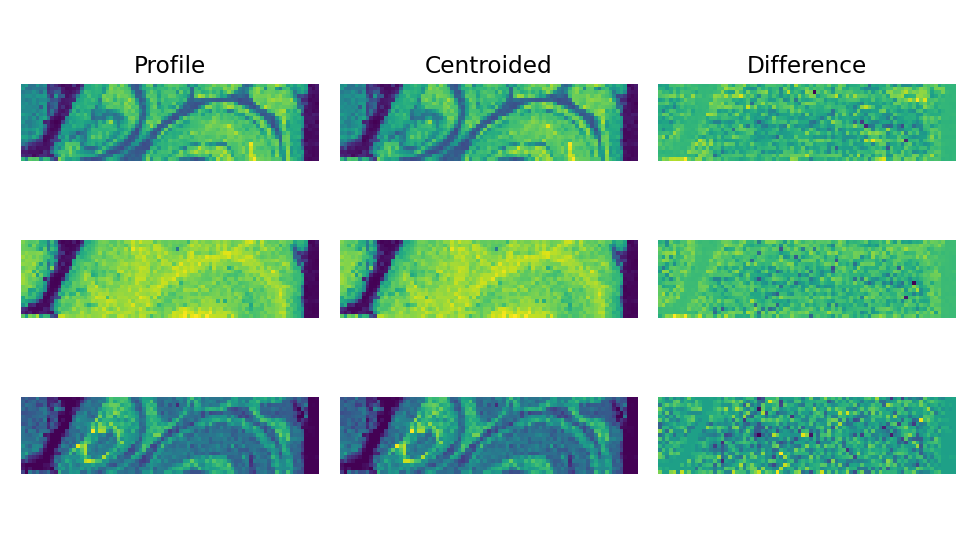

In [90]:
plt.figure(figsize=(7, 4))
plt.subplot(3, 3, 1)
plt.title('Profile')
plt.subplot(3, 3, 2)
plt.title('Centroided')
plt.subplot(3, 3, 3)
plt.title('Difference')
for i, n in enumerate(test_names):
    pim = profile_cerebellum_images[i]
    cim = centroided_cerebellum_images[i]
    plt.subplot(3, 3, 1+3*i)
    plt.imshow(pim)
    plt.axis('off')
    plt.subplot(3, 3, 2+3*i)
    plt.imshow(cim)
    plt.axis('off')
    plt.subplot(3, 3, 3+3*i)
    plt.imshow(pim/np.sum(pim) - cim/np.sum(cim))
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/Preprocessing/cerebellum_centroid_validation_images.png', dpi=300)

The spatial distributions in the profile and centroided images are visually identical. The difference is distributed mostly randomly, showing that the differences between profile and centroided images are mostly due to numerical processing and confirming a correct centroiding.  

Inspect the bladder:

<IPython.core.display.Javascript object>


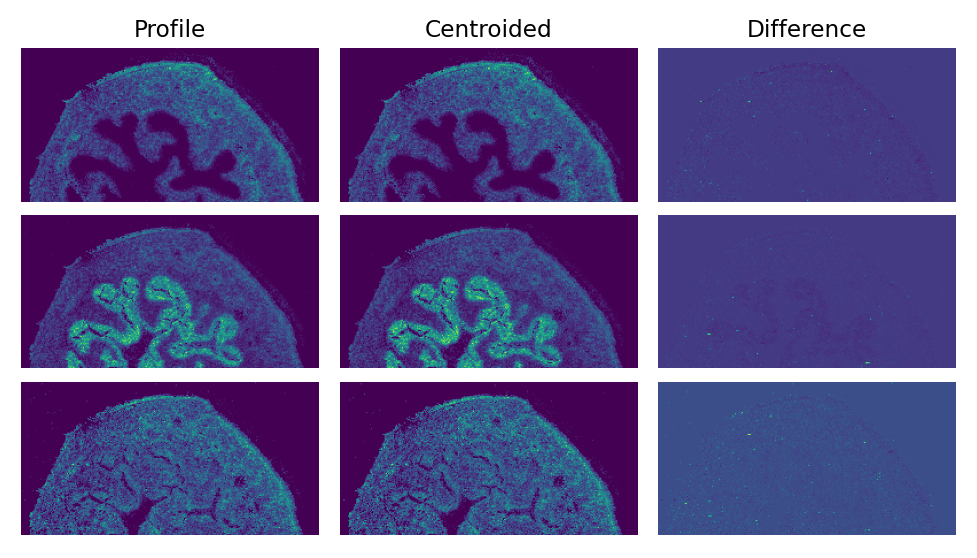

In [91]:
plt.figure(figsize=(7, 4))
plt.subplot(3, 3, 1)
plt.title('Profile')
plt.subplot(3, 3, 2)
plt.title('Centroided')
plt.subplot(3, 3, 3)
plt.title('Difference')
for i, n in enumerate(test_names):
    pim = profile_bladder_images[i]
    cim = centroided_bladder_images[i]
    plt.subplot(3, 3, 1+3*i)
    plt.imshow(pim)
    plt.axis('off')
    plt.subplot(3, 3, 2+3*i)
    plt.imshow(cim)
    plt.axis('off')
    plt.subplot(3, 3, 3+3*i)
    plt.imshow(pim/np.sum(pim) - cim/np.sum(cim))
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/Preprocessing/bladder_centroid_validation_images.png', dpi=300)

Same thing.  

Inspect randomly selected spectra:

In [92]:
idx = 1000
bdr_ctr = Spectrum(confs=list(zip(*bladder_centroided_image.getspectrum(1000))))
bdr_prf = Spectrum(confs=list(zip(*bladder_image.getspectrum(1000))))
cer_ctr = Spectrum(confs=list(zip(*cerebellum_centroided_image.getspectrum(1000))))
cer_prf = Spectrum(confs=list(zip(*cerebellum_image.getspectrum(1000))))

<IPython.core.display.Javascript object>


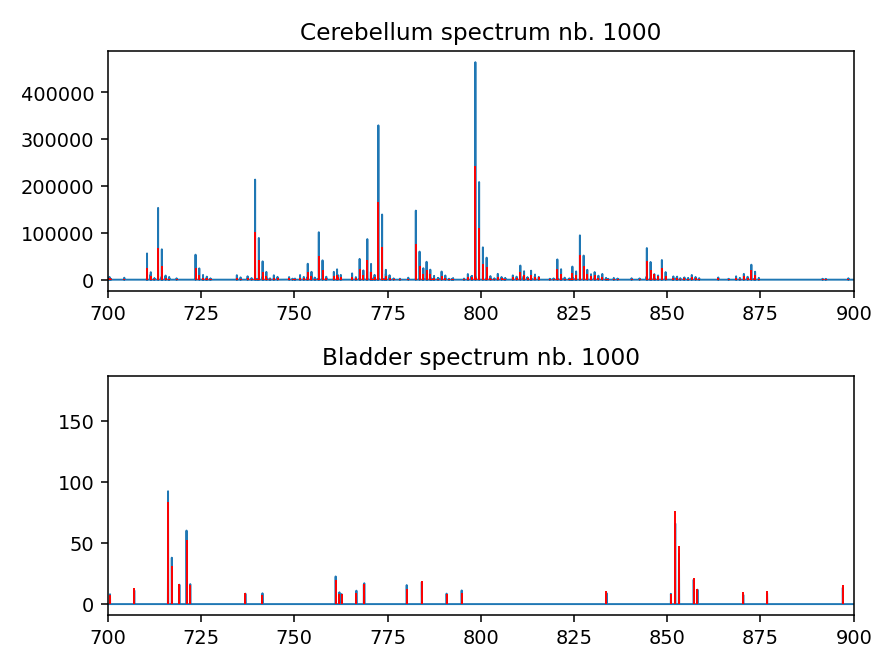

In [93]:
plt.figure()
plt.subplot(211)
(0.03*cer_prf).plot(profile=True)
cer_ctr.plot(color='r')
plt.xlim(*analyzed_mass_range)
plt.title('Cerebellum spectrum nb. %i' % idx)
plt.subplot(212)
(0.03*bdr_prf).plot(profile=True)
bdr_ctr.plot(color='r')
plt.title('Bladder spectrum nb. %i' % idx)
plt.xlim(*analyzed_mass_range)
plt.tight_layout()
plt.savefig('Figs/Preprocessing/centroiding_validation_pixel_spectra.png', dpi=300)

Looks good as well. Note that we didn't restrict the mz values when centroiding the spectra as when calculating the average ones, so we have both heavier and lighter peaks than in the average spectrum (e.g. peaks around 1000 Da). This is because we don't need to discard this information at this stage of the analysis - we'll save it in case we need it.   